In [1]:
%run _init.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [6]:
observed=pd.DataFrame(np.float_([[13,382], [1156, 48731]]),index=['Malformed', 'Normal'], columns=['Bendectin', 'Control']);
observed

,Bendectin,Control
Malformed,13.0,382.0
Normal,1156.0,48731.0


In [14]:
N_patients = observed.sum(axis=1) #rows
N_outcomes = observed.sum(axis=0) #cols
P_outcomes = N_outcomes / np.sum(N_outcomes) #probs

# columns contain the outcome we want to test
expected = pd.DataFrame(np.outer(N_patients,P_outcomes), index=['Malformed', 'Normal'], columns=['Bendectin', 'Control']);
print('expected = ',expected)
((observed-expected)**2/expected).sum(axis=1)

expected =               Bendectin       Control
Malformed     9.183306    385.816694
Normal     1159.816694  48727.183306


Malformed    1.624021
Normal       0.012859
dtype: float64

In [18]:
chi2Observed = st.chi2(observed);

observedLong = pd.DataFrame(
    utils.expandGrid(
        observed.index.tolist(),
        observed.columns.tolist(), 
        doPaste=False, 
        expansion = np.ravel(np.int64(observed), order='F')
    ), 
    columns=['Outcome', 'Drug']
);

observedLong.head(5)

,Outcome,Drug
0,Malformed,Bendectin
1,Malformed,Bendectin
2,Malformed,Bendectin
3,Malformed,Bendectin
4,Malformed,Bendectin


In [23]:
testTable = pd.crosstab(
    observedLong['Outcome'],
    observedLong['Drug']
);
#Pandas reorganizes stuff, let's make sure we get it back in order
testTable = testTable.loc[observed.index.tolist(),observed.columns.tolist()];
print(np.all(testTable==observed))
testTable

True


Drug,Bendectin,Control
Outcome,,
Malformed,13,382
Normal,1156,48731


In [21]:
# bootstrap
B = 10000
chi2_bootstraps = np.zeros(B);
chi2_NHST = np.zeros(B);
# make a copy of the data to run the nhst randomization
nhstData = observedLong.copy();
nRows = len(observedLong.index);

for b in range(B):
    # bootstrap for CI
    bootData = observedLong.sample(nRows,replace=True); #sample all rows
    # now get chiSquared
    bootTable = pd.crosstab(
        bootData['Outcome'],
        bootData['Drug']
    );
    #Pandas reorganizes stuff, let's make sure we get it back in order
    #using the original table's ordering
    bootTable = bootTable.loc[observed.index.tolist(),observed.columns.tolist()];
    #compute this iteration X2
    chi2_bootstraps[b] = st.chi2(bootTable)
    
    # NHST randomization
    nullOutcome = observedLong['Outcome'].sample(nRows,replace=True);
    nhstData['Outcome'] = nullOutcome.values;
    NHSTTable = pd.crosstab(
        nhstData['Outcome'],
        nhstData['Drug']
    );
    #Pandas reorganizes stuff, let's make sure we get it back in order
    NHSTTable = NHSTTable.loc[observed.index.tolist(),observed.columns.tolist()];
    chi2_NHST[b] = st.chi2(NHSTTable)

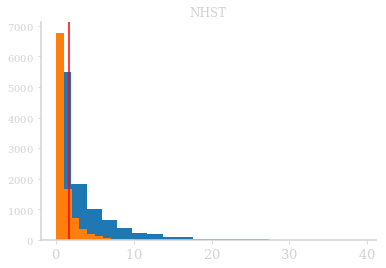

In [22]:
pyp.hist(chi2_bootstraps,bins=20)
pyp.hist(chi2_NHST, bins=20);
ax = pyp.gca();
ax.set_title('NHST');
ax.axvline(chi2Observed, color='red');

In [7]:
def x2boot(observed, margin=0, B=100):
  '''
    Computes chi-squared and bootstrap NHST
    margin input indicates which margin of the observed contingency table
    contains the outcome varaible where 0=index (rows) and 1=columns
  '''
  x2_observed = st.chi2(observed);
  #detect margin and force outcome in 1st column
  if not margin:
    outcome_ = observed.index.tolist();
    test_ = observed.columns.tolist();
  else:
    outcome_ = observed.columns.tolist();
    test_ = observed.index.tolist();
  observedLong = pd.DataFrame(
    utils.expandGrid(
        outcome_,
        test_, 
        doPaste=False, 
        expansion = np.ravel(np.int64(observed), order='F')
    ), 
    columns=['Outcome', 'Test']
  );
  #boot
  chi2_NHST = np.zeros(B);
  # make a copy of the data to run the nhst randomization
  nhstData = observedLong.copy();
  nRows = len(observedLong.index);
  for b in range(B):
      # NHST randomization
      nullOutcome = observedLong['Outcome'].sample(nRows,replace=True);
      nhstData['Outcome'] = nullOutcome.values;
      NHSTTable = pd.crosstab(
          nhstData['Outcome'],
          nhstData['Test']
      );
      #Pandas reorganizes stuff, let's make sure we get it back in order
      NHSTTable = NHSTTable.loc[outcome_,test_];
      chi2_NHST[b] = st.chi2(NHSTTable)
  return {
    'Bootstraps': chi2_NHST,
    'Observed': x2_observed,
    'pvalue': np.mean(chi2_NHST >= x2_observed)
  }
  

In [ ]:
pvals = np.zeros(1000);
for p in range(1000):
  test = x2fun(observed,margin=0,B=2000);
  pvals[p] = test['pvalue'];

0.205


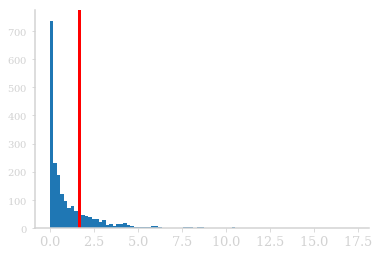

In [15]:
pyp.hist(test['Bootstraps'],bins='fd');
pyp.axvline(test['Observed'], lw=3,color='red');
print(test['pvalue']);

In [16]:
np.mean(pvals < 0.05)

array([0.1885, 0.195 , 0.2025, 0.1985, 0.205 ])

# $\chi^2$ quickie

In [2]:
observed = pd.DataFrame(np.int64([[60,40],[50,50]]), index = ['Male', 'Female'], columns = ['Yes','No']);
observed

,Yes,No
Male,60,40
Female,50,50


### Recall:

$$\chi^2 = \sum_{i}\sum_{j}\frac{(O_{ij}-E_{ij})^2}{E_{ij}}$$

For a given table:
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Yes</th>
      <th>No</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Male</th>
      <td>60</td>
      <td>40</td>
    </tr>
    <tr>
      <th>Female</th>
      <td>50</td>
      <td>50</td>
    </tr>
  </tbody>
</table>

We can compute the expected count for each cell using the $n_{group}\cdot p(\text{outcome})$ approach. So for the above table we get:

<table border="1">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Yes</th>
      <th>No</th>
    </tr>
  </thead>
  <tbody>
    <tr style="text-align: justify;">
      <th>Male</th>
      <td>$E(Y|M)=$$n_M\cdot p(Y)=$$100\times\frac{110}{200}=55$</td>
      <td>$E(N|M)=$$n_M\cdot p(N)=$$100\times\frac{90}{200}=45$</td>
    </tr>
    <tr style="text-align: justify;">
      <th>Female</th>
      <td>$E(Y|F)=$$n_F\cdot p(Y)=$$100\times\frac{110}{200}=55$</td>
      <td>$E(N|F)=$$n_F\cdot p(N)=$$100\times\frac{90}{200}=45$</td>
    </tr>
  </tbody>
</table>

Which can be neatly performed using the `outer` product, $\phantom{} \otimes\phantom{}$, such that $E(\, \text{Condition}|\, \text{Group}) = \overrightarrow{n_G}\otimes \overrightarrow{p_C}$, which becomes:

$$\begin{bmatrix} E(Y|M) & E(N|M) \\ E(Y|F) & E(N|F) \end{bmatrix} = \begin{bmatrix}n_M \\ n_F\end{bmatrix} \bigotimes\, ( p(Y)\, p(N))$$

With Python and the numpy and pandas libraries this is easy. 


In [3]:
# To get expected table
N_patients = observed.sum(axis=1) #rows
N_outcomes = observed.sum(axis=0) #cols
P_outcomes = N_outcomes / np.sum(N_outcomes) #probs

# columns contain the outcome we want to test
expected = pd.DataFrame(np.outer(N_patients,P_outcomes), index = ['Male', 'Female'], columns = ['Yes','No']);
print('expected = ',expected)
((observed-expected)**2/expected).sum(axis=1)

expected =           Yes    No
Male    55.0  45.0
Female  55.0  45.0


Male      1.010101
Female    1.010101
dtype: float64

$${\displaystyle \chi^{2}=\sum\frac{\left( O-E\right)^{2}}{E}}$$
$${\displaystyle O={\begin{pmatrix}60&40\\50&50\end{pmatrix}}}$$
$${\displaystyle E={\begin{pmatrix}55&45\\55&45\end{pmatrix}}}$$
$${\displaystyle \chi^{2}=\sum\frac{\left[ {\begin{pmatrix}\color{lightblue}{60}&\color{lightblue}{40}\\\color{red}{50}&\color{red}{50}\end{pmatrix}}-{\begin{pmatrix}55&45\\55&45\end{pmatrix}}\right]^{2}}{{\begin{pmatrix}55&45\\55&45\end{pmatrix}}}}$$


We can think of this like summing the $\chi^2$ for each category. In this case, that would be: ${\displaystyle \chi^2={\color{lightblue}\chi^{{\color{lightblue}2}}_{\color{lightblue}{Male}}}+{\color{red}\chi^{\color{red}2}_{\color{red}{Female}}}}$.

We can then expand our matrices to have:
$${\displaystyle \chi^2=\left[ \frac{\left( \color{lightblue}{60}-55\right)^{2}}{55}+\frac{\left( \color{lightblue}{40}-45\right)^{2}}{45}\right]_{\color{lightblue}{Male}}+\left[ \frac{\left( \color{red}{50}-55\right)^{2}}{55}+\frac{\left( \color{red}{50}-45\right)^{2}}{45}\right]_{\color{red}{Female}}}$$

$${\displaystyle \chi^2=\left[ \frac{25}{55}+\frac{25}{45}\right]_{\color{lightblue}{Male}} + \left[ \frac{25}{55}+\frac{25}{45}\right]_{\color{red}{Female}}}=1.01+1.01=2.02$$

## Fisher's exact Interlude

What about tables with small N?

$\chi^2$ requires the following conditions:
1. When any elements are zero, $\chi^2$ is not possible (think the process).
2. When any value is $\phantom{}<10$, the Gaussian assumptions in $\chi^2$ fails.
3. $\chi^2$ is generally defined with *free marginals*$^1$

For example, let's look at this small table:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Diabetes</th>
      <th>No Diabetes</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Male</th>
      <td>5</td>
      <td>1</td>
    </tr>
    <tr>
      <th>Female</th>
      <td>1</td>
      <td>4</td>
    </tr>
  </tbody>
</table>

If we demand that row and table totals (**marginals**) remain constant, then there are a finite number of possible tables. In this case, there are 6:
$${\displaystyle {\begin{pmatrix}6&0\\0&5\end{pmatrix}},\quad 
{\begin{pmatrix}5&1\\1&4\end{pmatrix}},\quad 
{\begin{pmatrix}4&2\\2&3\end{pmatrix}},\quad 
{\begin{pmatrix}3&3\\3&2\end{pmatrix}},\quad 
{\begin{pmatrix}2&4\\4&1\end{pmatrix}},\quad 
{\begin{pmatrix}1&5\\5&0\end{pmatrix}}.}$$

Thus, there are only 6 possible $chi^2$ values:
$$0.11,0.78,2.4,4.41,7.64, 11.00$$


Which makes it hard to interpret the $\chi^2$ distribution.


Muriel Bristol, a scientist the Rothamstead Experiment Station, claimed that she could tell the difference between a cup of tea in which the milk had been poured before the tea, and on in which the tea had been poured before the milk. Fisher, devised an experimnet in which he made 8 cups of tea, 4 of each method. This fixes row and column marginals (at 4 each). Ms Bristol was asked to taste each cup and assign 4 cups to each method.

By fixing the marginals, Fisher could then determine the probability of getting the *exact* table observed. He did this by combinatorics:

e.g. yourTable:
$${\displaystyle {\begin{pmatrix}a_1&a_2\\b_1&b_2\end{pmatrix}}}$$

$${\displaystyle p_{yourTable} = \frac{ \binom{a_1+a_2}{a_1} \binom{b_1+b_2}{b_1} }{ \binom{a_1+a_2+b_1+b_2}{a_1+b_1} } }$$

Which can be written as factorials:
$${\displaystyle \frac{ (a_1+a_2)!\, (b_1+b_2)!\, (a_1+b_1)!\, (a_2+b_2)!\,  }{ a_1!\,a_2!\,b_1!\,b_2!\,(a_1+a_2+b_1+b_2)! }}$$


But this gets crazy as the numbers get large, which can be seen even by just looking at the table of the first 15 factorials:
$${\displaystyle {\begin{pmatrix}0&1\\1&1\\2&2\\3&6\\4&24\\5&120\\6&720\\7&5,040\\8&40,320\\9&362,880\\10&3,628,800\\11&39,916,800\\12&479,001,600\\13&6,227,020,800\\14&87,178,291,200\end{pmatrix}}}$$


So what Fisher did, was compute the probabilities of all the possible tables (which sum to 1 if you have them all) and ordered them and summed up the ones that were as extreme or more extreme than the observed probability. For our Diabetes table:
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Diabetes</th>
      <th>No Diabetes</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Male</th>
      <td>5</td>
      <td>1</td>
    </tr>
    <tr>
      <th>Female</th>
      <td>1</td>
      <td>4</td>
    </tr>
  </tbody>
</table>

That was:

$${\displaystyle p_{diabetes}=\frac{ (5+1)!\, (1+4)!\, (5+1)!\, (1+4)!\,  }{ 5!\,1!\,1!\,4!\,(5+1+1+4)! }}= 0.0649351$$

And all the probabilities (sorted):

$\{ 0.0021645,\quad 0.012987,\quad 0.0649351,\quad 0.0162338,\quad 0.324675,\quad 0.4329\}$


So we sum the extreme probabilities: $p = \sum\{ 0.0649351,\quad 0.0021645,\quad 0.012987 \} = 0.08$

The bootstrap version of Fisher's Exact test (idiomatically, we call this Alan's inexact test):

<ol class="push-left">
    <li>
      Convert your contingency table into a data frame with 2 columns: One contains the <span class="mutedBlue">Outcome</span> labels, the other contains the <span class="red">Category</span> labels, and each row represents an observed pairing, e.g. rows 1 through 5 would each be: <code>(<span class="mutedBlue">Diabetes</span>, <span class="red">Male</span>)</code>.
    </li>
    <li class="fragment">
      Only <span class="mutedBlue em b">shuffle</span> the outcome variables, effectively randomizing the soda preferences for each individual.
    </li>
    <li class="fragment">
      Re-tabulate the data frame, creating a new <span class="mutedBlue">bootstrap</span> contingency table.
    </li>
    <li class="fragment">
      <span class="mutedBlue">Calculate the new table probability.
    </li>
    <li class="fragment">
      <span class="mutedBlue">Repeat this many times</span> (10000) to get a <span class="orange">randomization distribution</span> of many probabilites under the assumption that the null hypothesis is true.
    </li>
    <li class="fragment">
      Calculate the <span class="red">p-value</span> (one-tail).
    </li>
</ol>
---
$^1$ A marginal is the sum of rows or columns. A *free marginal* indicates that these sums can wiggle, like they do with the bootstrap.

In [4]:
from scipy.special import factorial
ss = '{\displaystyle {\\begin{pmatrix}'
for a in range(15):
  ss += f'{a}&{factorial(a,exact=True):d}\\\\'
ss += '\\\end{pmatrix}}}'
print(ss)


{\displaystyle {\begin{pmatrix}0&1\\1&1\\2&2\\3&6\\4&24\\5&120\\6&720\\7&5040\\8&40320\\9&362880\\10&3628800\\11&39916800\\12&479001600\\13&6227020800\\14&87178291200\\\\end{pmatrix}}}


## Back to big example

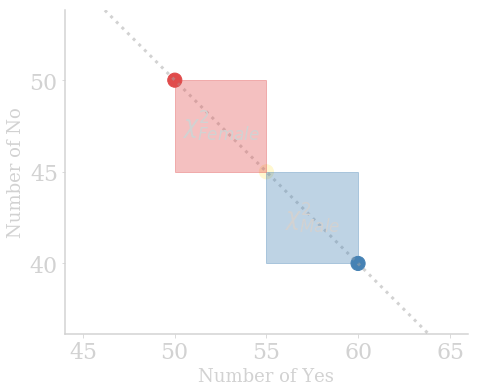

In [5]:
# plot squared dists
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

boy = col['satBlue']
girl = col['red']

pars = np.polyfit([60,50],[40,50],1);



fig = pyp.figure(figsize=(7,6))
axs = fig.add_axes([0.15, 0.2, 0.8, 0.75])
axs = utils.multiX(axs,n=2,concatFirst=True,concatOriginal=True); #3 ax

# initial scatter
axs[0].scatter([60,50,55],[40,50,45],color = [boy,girl,col['offwhite']],s=200);
axs[0].set_xlabel('Number of Yes');
axs[0].set_ylabel('Number of No');
axs[0].axis('equal');
axs[0].set_xlim((45,65));

# connecting line
x = axs[0].get_xlim()
axs[1].plot(x,np.polyval(pars,x), color = col['grey2'], lw=3, alpha=0.5,ls=':');

# x2 dists
squares = [
  patches.Rectangle((55,40), 5,5),
  patches.Rectangle((50,45), 5,5)
];
pcoll = PatchCollection(squares, alpha=0.35);
pcoll.set_color([boy,girl]);
axs[2].add_collection(pcoll);
axs[2].text(
  52.5,(50+45)/2, 
  r'$\chi^{2}_{Female}$',
  color=col['grey'],
  size=24,
  ha = 'center',
  va = 'center'
)
axs[2].text(
  (60+55)/2,(40+45)/2, 
  r'$\chi^{2}_{Male}$',
  color=col['grey'],
  size=24,
  ha = 'center',
  va = 'center'
)

for ax in axs:
  ax.patch.set_alpha(0);
  if ax != axs[0]:
      ax.spines['bottom'].set_visible(False);
      ax.spines['left'].set_visible(False);
      ax.set_yticks([]);
      ax.axis('equal');
      ax.set_xlim(axs[0].get_xlim());

  if ax is axs[0]:
      ax.tick_params(axis='both', labelsize = 22, direction= 'out');


fig.savefig('../img/chisquraedDist.svg', transparent=True);    

Now we need to use a few functions:

1. $\chi^2$ function
2. Let's wrap our code to compute the expected table in a function
3. Let's create a function that transforms a contingency table into a long-form data frame for resampling

In [6]:
# Convert table to long form data
chi2Observed = st.chi2(observed);

observedLong = pd.DataFrame(
    utils.expandGrid(
        observed.index.tolist(),
        observed.columns.tolist(), 
        doPaste=False, 
        expansion = np.ravel(observed, order='F')
    ), 
    columns=['Gender', 'Outcome']
);

observedLong.head(5)

,Gender,Outcome
0,Male,Yes
1,Male,Yes
2,Male,Yes
3,Male,Yes
4,Male,Yes


In [7]:
# Test that we can reconstruct the table
testTable = pd.crosstab(
    observedLong['Gender'],
    observedLong['Outcome']
);
#Pandas reorganizes stuff, let's make sure we get it back in order
testTable = testTable.loc[observed.index.tolist(),observed.columns.tolist()];
print(testTable==observed)
testTable

Outcome   Yes    No
Gender             
Male     True  True
Female   True  True


Outcome,Yes,No
Gender,,
Male,60,40
Female,50,50


In [8]:
# bootstrap
B = 10000
chi2_bootstraps = np.zeros(B);
chi2_NHST = np.zeros(B);
# make a copy of the data to run the nhst randomization
nhstData = observedLong.copy();
nRows = len(observedLong.index);

for b in range(B):
    # bootstrap for CI
    bootData = observedLong.sample(nRows,replace=True); #sample all rows
    # now get chiSquared
    bootTable = pd.crosstab(
        bootData['Gender'],
        bootData['Outcome']
    );
    #Pandas reorganizes stuff, let's make sure we get it back in order
    #using the original table's ordering
    bootTable = bootTable.loc[observed.index.tolist(),observed.columns.tolist()];
    #compute this iteration X2
    chi2_bootstraps[b] = st.chi2(bootTable)
    
    # NHST randomization
    nullOutcome = observedLong['Outcome'].sample(nRows,replace=True);
    nhstData['Outcome'] = nullOutcome.values;
    NHSTTable = pd.crosstab(
        nhstData['Gender'],
        nhstData['Outcome']
    );
    #Pandas reorganizes stuff, let's make sure we get it back in order
    NHSTTable = NHSTTable.loc[observed.index.tolist(),observed.columns.tolist()];
    chi2_NHST[b] = st.chi2(NHSTTable)


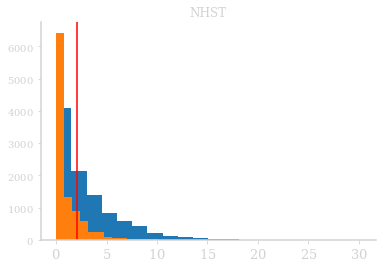

In [9]:
pyp.hist(chi2_bootstraps,bins=20)
pyp.hist(chi2_NHST, bins=20);
ax = pyp.gca();
ax.set_title('NHST');
ax.axvline(chi2Observed, color='red');

In [10]:
np.mean(chi2_NHST >= chi2Observed)

0.1578

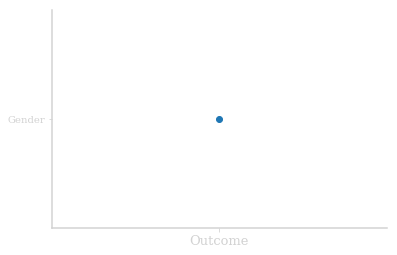

In [13]:
pyp.scatter('Outcome', 'Gender')

In [14]:
# Testing better CI bootstrap
# The idea is you fix the categories and restrict resampling to just reandomize within each category
cidata = observedLong.copy();
b=0
for b in range(B):
    cats = observed.index.tolist()
    for cat in cats:
        cidata['Outcome'][cidata['Gender']==cat] = \
            observedLong['Outcome'][observedLong['Gender']==cat].sample(
                np.sum(observedLong['Gender']==cat),
                replace=True
            );
    ciTable = pd.crosstab(
        cidata['Gender'],
        cidata['Outcome']
    );
    #Pandas reorganizes stuff, let's make sure we get it back in order
    #using the original table's ordering
    ciTable = ciTable.loc[observed.index.tolist(),observed.columns.tolist()];
    #compute this iteration X2
    chi2_bootstraps[b] = st.chi2(ciTable)

In [15]:
epsil = np.random.logistic(size=len(chi2_bootstraps), scale=1)
(chi2_bootstraps+epsil)/(np.max(chi2_bootstraps)-(chi2_bootstraps+epsil))

array([ 0.19627523,  0.04486131, -0.01391494, ..., -0.0453754 ,
        0.00724151,  0.06851728])

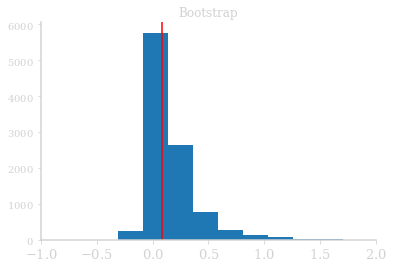

In [16]:
pyp.hist((chi2_bootstraps+epsil)/(np.max(chi2_bootstraps)-(chi2_bootstraps+epsil)), bins=500);
ax = pyp.gca();
ax.set_title('Bootstrap');
ax.set_xlim((-1,2))
ax.axvline(chi2Observed/(np.max(chi2_bootstraps)-chi2Observed),color='red');

# Hospitals data

In [17]:
import feather
hospitals = feather.read_dataframe('data/hospitals.feather')
hNames = ['Cedars Sinai', 'UCLA Harbor', 'UCLA Olive View', 'UCLA Ronald Reagan', 'UCLA Santa Monica', 'Kaiser LA'];
def mapper(xi):
    return(hNames[xi])
hospitals.rename(mapper,axis='index',inplace=True)
hospitals = hospitals.T
hospitals.applymap(np.int64)

,Cedars Sinai,UCLA Harbor,UCLA Olive View,UCLA Ronald Reagan,UCLA Santa Monica,Kaiser LA
Alive,20193,743,419,4752,5284,1280
Dead,4458,207,84,1065,1135,38


In [18]:
hospitals

,Cedars Sinai,UCLA Harbor,UCLA Olive View,UCLA Ronald Reagan,UCLA Santa Monica,Kaiser LA
Alive,20193.0,743.0,419.0,4752.0,5284.0,1280.0
Dead,4458.0,207.0,84.0,1065.0,1135.0,38.0


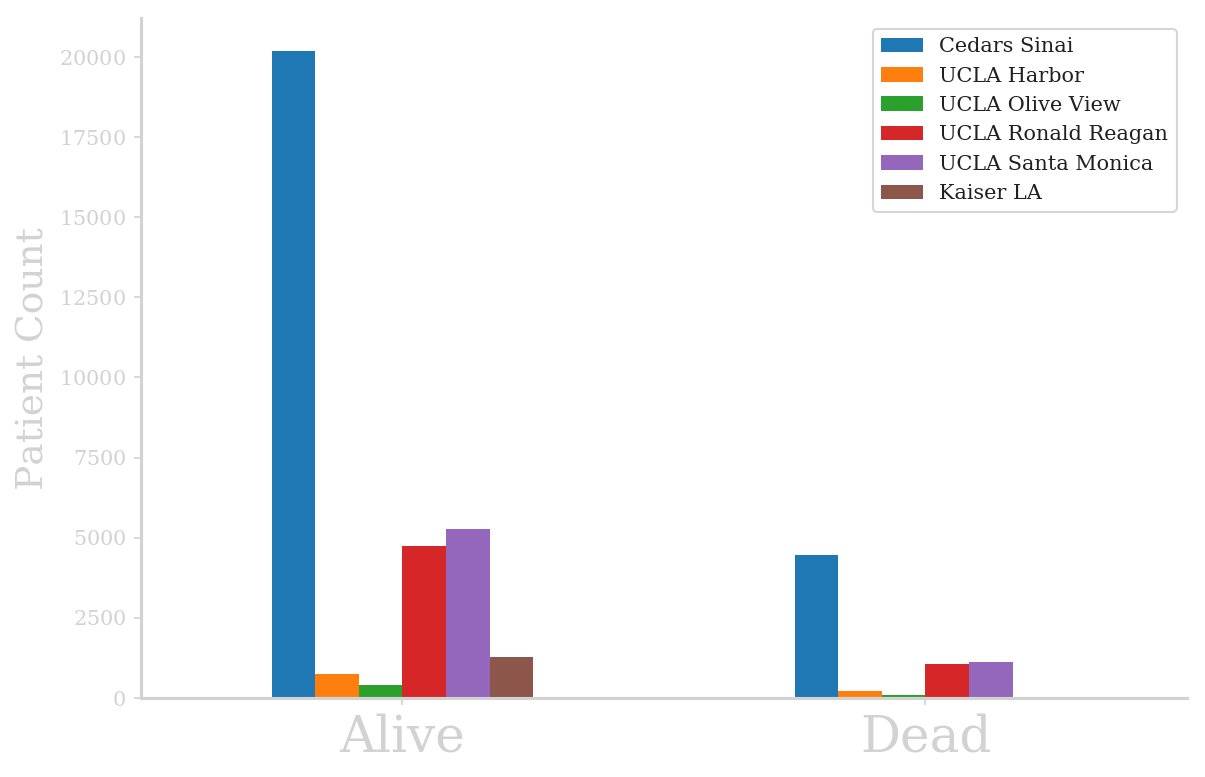

In [19]:
# normal axis scale
fig = pyp.figure(figsize=(9,6), dpi=150)
ax = fig.subplots();

hospitals.plot(ax = ax, kind="bar");
leg = ax.get_legend();
for text in leg.get_texts():
    text.set_color(col['dkGrey']);
ax.tick_params(axis='x', labelsize=24, labelrotation=0);
ax.set_ylabel('Patient Count');
ax.patch.set_alpha(0)
fig.savefig("../img/hospitals.svg", transparent=True);

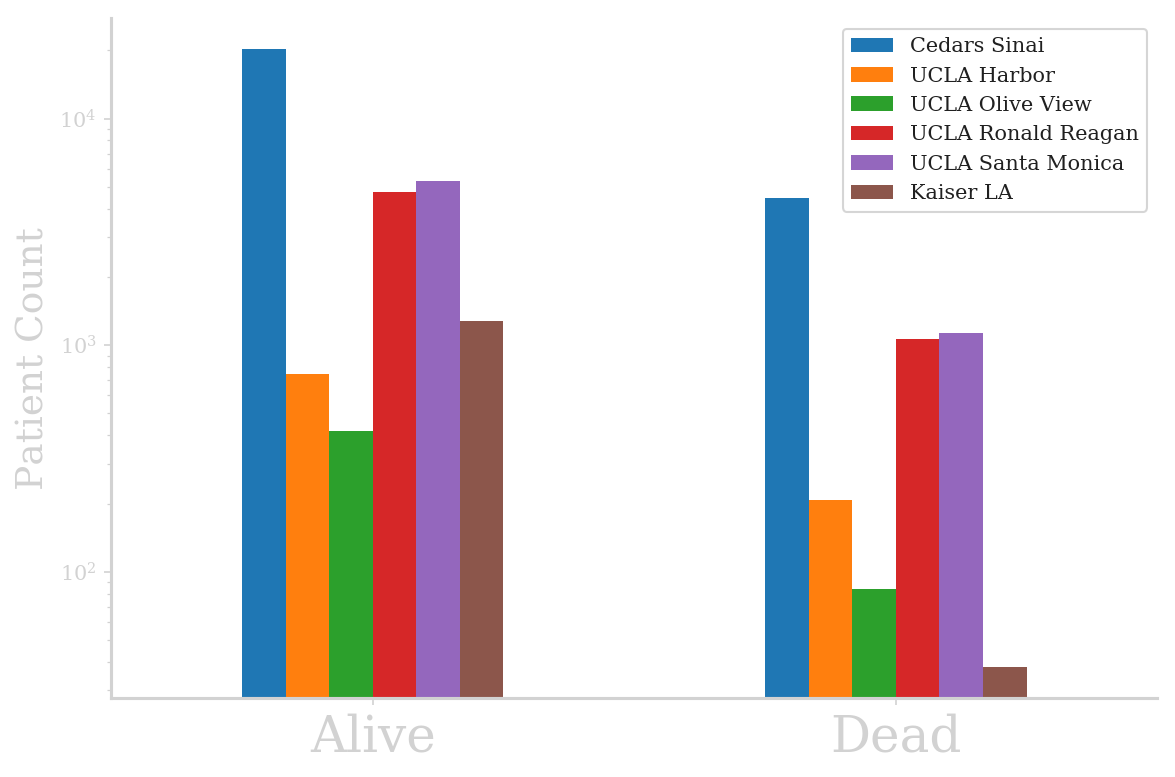

In [20]:
fig = pyp.figure(figsize=(9,6), dpi=150)
ax = fig.subplots();

hospitals.plot(ax = ax, kind="bar", logy=True);
leg = ax.get_legend();
for text in leg.get_texts():
    text.set_color(col['dkGrey']);
ax.tick_params(axis='x', labelsize=24, labelrotation=0);
ax.set_ylabel('Patient Count');
ax.patch.set_alpha(0);
fig.savefig("../img/hospitals_log.svg", transparent=True);

In [21]:
hospitals

,Cedars Sinai,UCLA Harbor,UCLA Olive View,UCLA Ronald Reagan,UCLA Santa Monica,Kaiser LA
Alive,20193.0,743.0,419.0,4752.0,5284.0,1280.0
Dead,4458.0,207.0,84.0,1065.0,1135.0,38.0


In [22]:
hexpect = st.expectTable(hospitals)
hexpect

,Cedars Sinai,UCLA Harbor,UCLA Olive View,UCLA Ronald Reagan,UCLA Santa Monica,Kaiser LA
Alive,20307.953528,782.627717,414.380781,4792.153084,5288.091911,1085.79298
Dead,4343.046472,167.372283,88.619219,1024.846916,1130.908089,232.20702


In [23]:
forFits=np.vstack([hospitals.loc['Dead'],hospitals.loc['Alive'],hexpect.loc['Dead'],hexpect.loc['Alive']]).reshape((2,-1))
pd.DataFrame(forFits, index=['X','Y'])

,0,1,2,3,4,5,6,7,8,9,10,11
X,4458.000000,207.000000,84.000000,1065.000000,1135.000000,38.00000,20193.000000,743.000000,419.000000,4752.000000,5284.000000,1280.00000
Y,4343.046472,167.372283,88.619219,1024.846916,1130.908089,232.20702,20307.953528,782.627717,414.380781,4792.153084,5288.091911,1085.79298


In [24]:
for i in range(0,12,2):
  print(i)


0
2
4
6
8
10


In [25]:
# plot squared dists


colKeys = ['blue', 'orange', 'green', 'red', 'purple', 'grey'];
cols = [col[k] for k in colKeys];

pars = [];
for i in range(6):
  pars.append(np.polyfit(forFits[:,i],forFits[:,i+6],1));
print(pars)

[array([-1.0000e+00,  2.4651e+04]), array([ -1., 950.]), array([ -1., 503.]), array([-1.000e+00,  5.817e+03]), array([-1.000e+00,  6.419e+03]), array([-1.000e+00,  1.318e+03])]


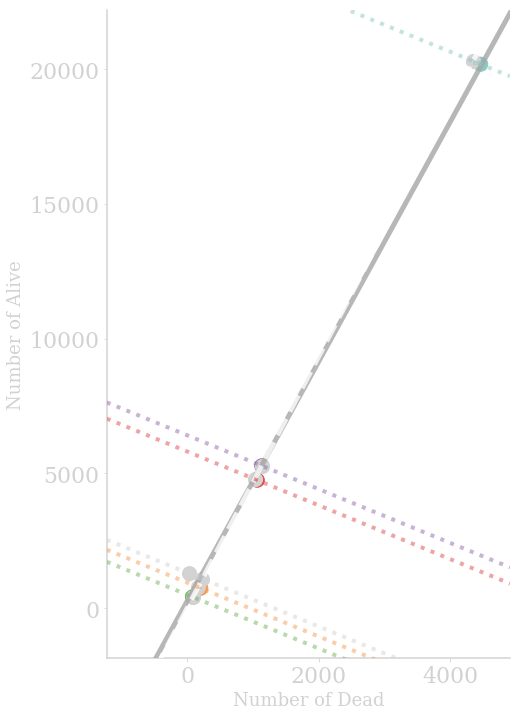

In [26]:
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

onefit = np.polyfit(
  hospitals.loc['Dead'],
  hospitals.loc['Alive'],
  1
);
expfit = np.polyfit(
  hexpect.loc['Dead'],
  hexpect.loc['Alive'],
  1
);

fig = pyp.figure(figsize=(7,12))
axs = fig.add_axes([0.15, 0.2, 0.8, 0.75])
axs = utils.multiX(axs,n=3,concatFirst=True,concatOriginal=True); #4 ax

# initial scatter
axs[0].scatter(
  hospitals.loc['Dead'],
  hospitals.loc['Alive'],
  color = cols,
  s=200);
axs[0].scatter(
  hexpect.loc['Dead'],
  hexpect.loc['Alive'],
  color = col['grey'],
  s=200
);
axs[0].set_xlabel('Number of Dead');
axs[0].set_ylabel('Number of Alive');
#axs[0].set_aspect('equal');
axs[0].set_ylim((axs[0].get_ylim()[0]-1000,hospitals.loc['Alive'].max()*1.1));
axs[0].set_xlim((axs[0].get_xlim()[0]-1000,hospitals.loc['Dead'].max()*1.1));


# connecting line
x = axs[0].get_xlim()
for i in range(len(pars)):
  axs[2].plot(x,np.polyval(pars[i],x), color = cols[i], lw=4, alpha=0.5,ls=':');

axs[1].plot(x,np.polyval(onefit,x), color = col['grey2'], lw=5, alpha = 0.8);
axs[1].plot(x,np.polyval(expfit,x), color = 'white', ls = '--',lw=5, alpha = 0.8);
# x2 dists
squares = [];
for i in range(hospitals.shape[1]):
  side = np.abs(hospitals.loc['Alive'][i]-hexpect.loc['Alive'][i]);
  bot = np.abs(hospitals.loc['Dead'][i]-hexpect.loc['Dead'][i]);
  if hospitals.loc['Alive'][i]>=hexpect.loc['Alive'][i]:
    #if data point above, lower left is not point
    lw_x, lw_y = (hospitals.loc['Dead'][i]), (hospitals.loc['Alive'][i]-side)
  else:
    #if data point below, lower left is the point
    lw_x, lw_y = hospitals.loc['Dead'][i]-bot, hospitals.loc['Alive'][i]
  squares.append(patches.Rectangle((lw_x, lw_y), side, bot))
pcoll = PatchCollection(squares, alpha=0.35);
pcoll.set_color(cols);
axs[3].add_collection(pcoll);
# axs[2].text(
#   52.5,(50+45)/2, 
#   r'$\chi^{2}_{Female}$',
#   color=col['grey'],
#   size=24,
#   ha = 'center',
#   va = 'center'
# )
# axs[2].text(
#   (60+55)/2,(40+45)/2, 
#   r'$\chi^{2}_{Male}$',
#   color=col['grey'],
#   size=24,
#   ha = 'center',
#   va = 'center'
# )

for ax in axs:
  ax.patch.set_alpha(0);
  if ax != axs[0]:
      ax.spines['bottom'].set_visible(False);
      ax.spines['left'].set_visible(False);
      ax.set_yticks([]);
      #ax.axis('equal');
      #ax.set_xlim(axs[0].get_xlim());
      ax.set_ylim(axs[0].get_ylim());

  if ax is axs[0]:
      ax.tick_params(axis='both', labelsize = 22, direction= 'out');



fig.savefig('../img/hospDist.svg', transparent=True);    

In [27]:
hospitals.loc['Alive'][1]

743.0

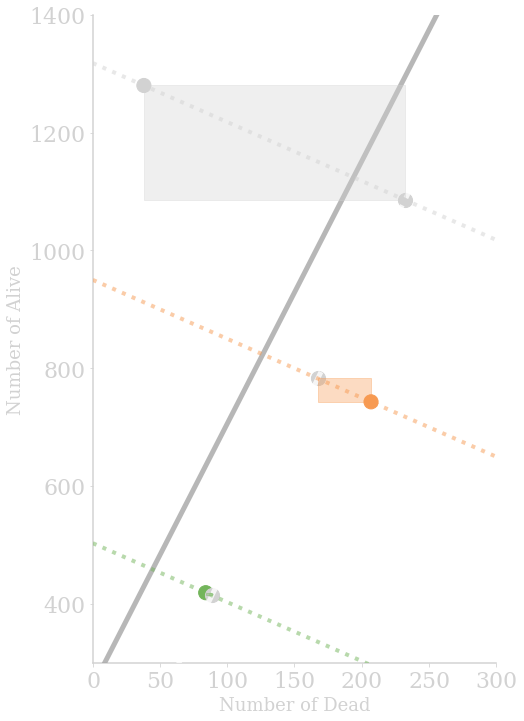

In [28]:
#truncate for squares
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

onefit = np.polyfit(
  hospitals.loc['Dead'],
  hospitals.loc['Alive'],
  1
);
expfit = np.polyfit(
  hexpect.loc['Dead'],
  hexpect.loc['Alive'],
  1
);

fig = pyp.figure(figsize=(7,12))
axs = fig.add_axes([0.15, 0.2, 0.8, 0.75])
axs = utils.multiX(axs,n=3,concatFirst=True,concatOriginal=True); #4 ax

# initial scatter
axs[0].scatter(
  hospitals.loc['Dead'],
  hospitals.loc['Alive'],
  color = cols,
  s=200);
axs[0].scatter(
  hexpect.loc['Dead'],
  hexpect.loc['Alive'],
  color = col['grey'],
  s=200
);
axs[0].set_xlabel('Number of Dead');
axs[0].set_ylabel('Number of Alive');
#axs[0].set_aspect('equal');
axs[0].set_ylim((300,1400));
axs[0].set_xlim((0,300));

# connecting line
x = axs[0].get_xlim()
for i in range(len(pars)):
  axs[2].plot(x,np.polyval(pars[i],x), color = cols[i], lw=4, alpha=0.5,ls=':');

axs[1].plot(x,np.polyval(onefit,x), color = col['grey2'], lw=5, alpha = 0.8);
axs[1].plot(x,np.polyval(expfit,x), color = 'white', ls = '--',lw=5, alpha = 0.8);
# x2 dists
squares = [];
for i in range(hospitals.shape[1]):
  side = np.abs(hospitals.loc['Alive'][i]-hexpect.loc['Alive'][i]);
  bot = np.abs(hospitals.loc['Dead'][i]-hexpect.loc['Dead'][i]);
  if hospitals.loc['Alive'][i]>=hexpect.loc['Alive'][i]:
    #if data point above, lower left is not point
    lw_x, lw_y = (hospitals.loc['Dead'][i]), (hospitals.loc['Alive'][i]-side)
  else:
    #if data point below, lower left is the point
    lw_x, lw_y = hospitals.loc['Dead'][i]-bot, hospitals.loc['Alive'][i]
  squares.append(patches.Rectangle((lw_x, lw_y), side, bot))
pcoll = PatchCollection(squares, alpha=0.35);
pcoll.set_color(cols);
axs[3].add_collection(pcoll);
# axs[2].text(
#   52.5,(50+45)/2, 
#   r'$\chi^{2}_{Female}$',
#   color=col['grey'],
#   size=24,
#   ha = 'center',
#   va = 'center'
# )
# axs[2].text(
#   (60+55)/2,(40+45)/2, 
#   r'$\chi^{2}_{Male}$',
#   color=col['grey'],
#   size=24,
#   ha = 'center',
#   va = 'center'
# )

for ax in axs:
  ax.patch.set_alpha(0);
  if ax != axs[0]:
      ax.spines['bottom'].set_visible(False);
      ax.spines['left'].set_visible(False);
      ax.set_yticks([]);
      #ax.axis('equal');
      #ax.set_xlim(axs[0].get_xlim());
      ax.set_ylim(axs[0].get_ylim());

  if ax is axs[0]:
      ax.tick_params(axis='both', labelsize = 22, direction= 'out');


fig.savefig('../img/HospDistZoom.svg', transparent=True);    

In [29]:
# Chi Squared
x2Hosp = st.chi2(hospitals)
print(x2Hosp)

214.46397237079773


In [30]:
hospitals.applymap(np.int64).values.flatten('F')

array([20193,  4458,   743,   207,   419,    84,  4752,  1065,  5284,
        1135,  1280,    38], dtype=int64)

In [31]:
hLong= pd.DataFrame(
  utils.expandGrid(
    hospitals.index.tolist(),
    hospitals.columns.tolist(),
    doPaste= False,
    expansion= hospitals.applymap(np.int64).values.flatten('F')
  ),
  columns = ['Survival', 'Hospitals']
);
hLong.iloc[np.r_[0:3,-4:-1]]

,Survival,Hospitals
0,Alive,Cedars Sinai
1,Alive,Cedars Sinai
2,Alive,Cedars Sinai
39654,Dead,Kaiser LA
39655,Dead,Kaiser LA
39656,Dead,Kaiser LA


In [32]:
### NOT RUN

# Bootstrap
B = 10000
hBoots = np.zeros(B);
hNHST = np.zeros(B);
# make a copy of the data to run the nhst randomization
nhstData = hLong.copy();
cidata = hLong.copy();
nRows = len(hLong.index);

for b in range(B):
  # bootstrap for CI
  cats = hospitals.columns.tolist()
  for cat in cats:
    cidata['Survival'][cidata['Hospitals']==cat] = \
        hLong['Survival'][hLong['Hospitals']==cat].sample(
            np.sum(hLong['Hospitals']==cat),
            replace=True
        );
  ciTable = pd.crosstab(
      cidata['Hospitals'],
      cidata['Survival']
  );
  #Pandas reorganizes stuff, let's make sure we get it back in order
  #using the original table's ordering
  ciTable = ciTable.loc[hospitals.columns.tolist(),hospitals.index.tolist()];
  #compute this iteration X2
  hBoots[b] = st.chi2(ciTable)

  # NHST randomization
  nullOutcome = hLong['Survival'].sample(nRows,replace=True);
  nhstData['Survival'] = nullOutcome.values;
  NHSTTable = pd.crosstab(
      nhstData['Hospitals'],
      nhstData['Survival']
  );
  #Pandas reorganizes stuff, let's make sure we get it back in order
  NHSTTable = NHSTTable.loc[hospitals.columns.tolist(),hospitals.index.tolist()];
  hNHST[b] = st.chi2(NHSTTable)
bootTable = pd.DataFrame(np.vstack([hBoots,hNHST]).T,columns=['Bootstraps', 'Null']);
bootTable.to_csv('./data/hospitalBootstraps.csv',index=False);


In [33]:
### RUN THIS

bootTable = pd.read_csv('./data/hospitalBootstraps.csv');
bootTable.head(10)

,Bootstraps,Null
0,225.113343,7.007240
1,240.971218,9.080715
2,205.509624,3.966002
3,215.414308,5.895708
4,241.863952,5.307128
5,210.445704,3.346789
6,211.734359,3.937182
7,213.297341,6.577734
8,219.590396,4.825577
9,224.566209,2.192004


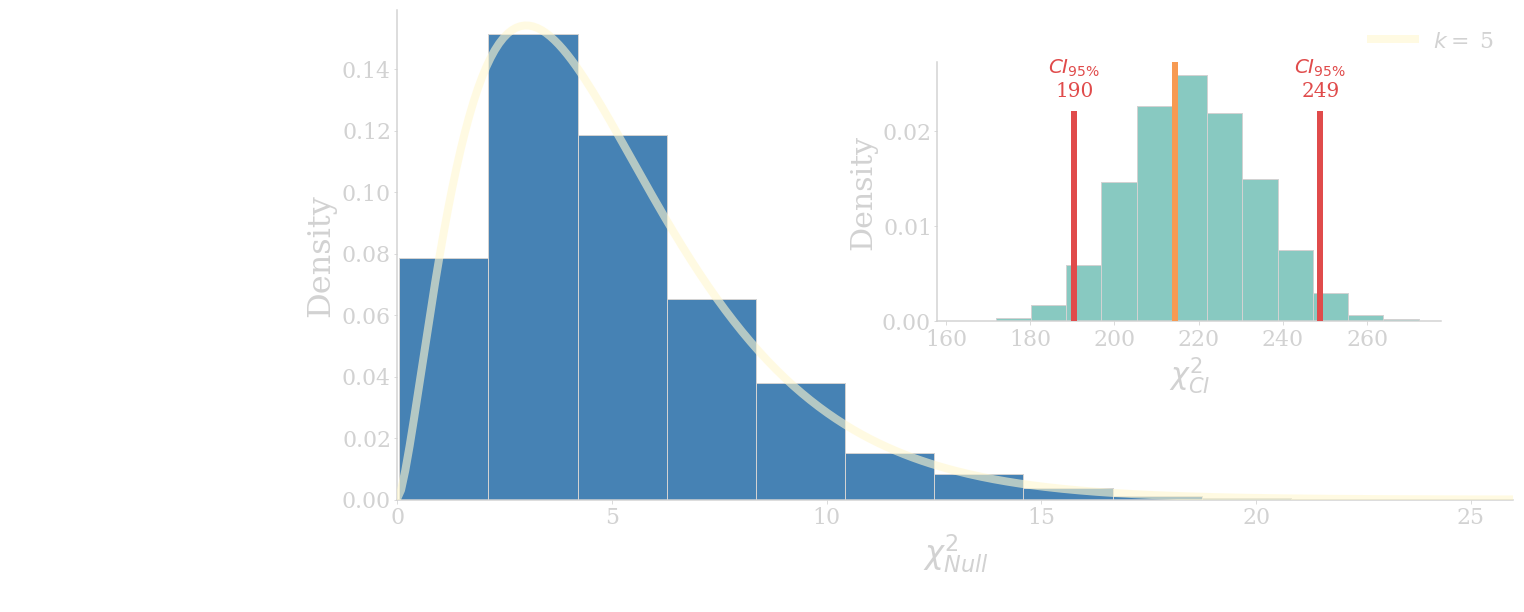

In [34]:
dof = (len(hospitals.index)-1)*(len(hospitals.columns)-1)
bins = 13
numP = np.sum(bootTable['Null'] >= x2Hosp)
p = np.mean(bootTable['Null'] >= x2Hosp)
if not p:
  p = r'$p<\frac{1}{10000}$'
else:
  p = r'$p=$' + f'${p:.4f}'

fig = pyp.figure(figsize=(20,9))
axs = fig.subplots();
axs = utils.multiX(ax=axs,n=2,concatOriginal=True,concatFirst=True);

'''
0 = base hist and axes lines/labels
1 = annotations (x2 act, etc)
2 = theory overlay
'''

# The histogram
axs[0].hist(
  bootTable['Null'], 
  density= True, 
  bins= bins, 
  color= col['satBlue'],
  edgecolor= col['grey']
);
axs[0].set_xlabel(r'$\chi^{2}_{Null}$', size=32);
axs[0].set_ylabel('Density', size=32);

# annotations
axs[1].annotate(
    r'$\chi^{2}_{Hospitals}$' + f' = {x2Hosp:,.0f}',
    xy = (axs[1].get_xlim()[1],0.1*axs[1].get_ylim()[1]),
    xytext = (0.8*axs[1].get_xlim()[1],0.1*axs[1].get_ylim()[1]),
    color = col['orange'],
    size=32,
    ha = 'right',
    va = 'center',
    arrowprops= {
        'arrowstyle': 'fancy',
        'edgecolor': col['orange'],
        'facecolor': col['orange']
    },
    zorder=100
);

# Theory
x = np.linspace(*axs[0].get_xlim(),300)
axs[2].plot(
  x, 
  stats.chi2.pdf(x, dof), 
  lw=8, 
  alpha=0.6, 
  label=f"$k=$ {dof}", 
  color=col['offwhite']
);
axs[2].legend(loc='upper right', frameon=False, fontsize=22);
axs[2].patch.set_alpha(0)
axs[2].set_ylim(axs[0].get_ylim());

# Add CI overset
ax2 = fig.add_axes([0.5,0.4,0.35,0.4]);
ax2.hist(
  bootTable['Bootstraps'], 
  density= True, 
  bins= bins, 
  color= col['blue'],
  edgecolor= col['grey']
);
ax2.set_xlabel(r'$\chi^{2}_{CI}$', size=30);
ax2.set_ylabel('Density', size=30);

ax2.patch.set_alpha(0);
ax2.tick_params(axis='both', labelsize=18, direction='out');

#ax2 overlay
ci95 = np.percentile(bootTable['Bootstraps'], q=[2.5, 97.5])
ax3 = ax2.twinx();
ax3.axvline(x2Hosp, lw=6, color=col['orange']);
for ci in ci95:
  ax3.axvline(ci, lw=6, color=col['red'], ymax=0.8);
  ax3.text(
    ci, 
    ax3.get_ylim()[1]*0.85, 
    r'$CI_{95\%}$'+f'\n{ci:.0f}', 
    ha="center",
    color=col['red'], 
    size=20, 
    va="bottom"
  );
ax3.set_xlim(ax2.get_xlim());

for ax in axs+[ax2,ax3]:
    ax.patch.set_alpha(0);
    if ax not in [axs[0],ax2]:
      ax.spines['bottom'].set_visible(False)
      ax.spines['left'].set_visible(False)
      ax.set_yticks([]);
    if ax in [axs[0],ax2]:
        ax.tick_params(axis='both', labelsize = 22, direction= 'out');
for ax in axs:
  ax.set_xlim((0,26));


fig.savefig('../img/HospitalChi2.svg', transparent=True);

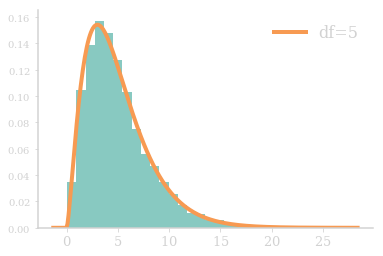

In [35]:
###
pyp.hist(bootTable['Null'], density=True, bins = 30, color=col['blue']);
ax = pyp.gca();
x = np.linspace(*ax.get_xlim(),300)
ax.plot(x, stats.chi2.pdf(x, dof), lw=4, alpha=1, label=f"df={dof}", color=col['orange']);
ax.legend(loc='upper right', frameon=False, fontsize=16);
ax.patch.set_alpha(0)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:141: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


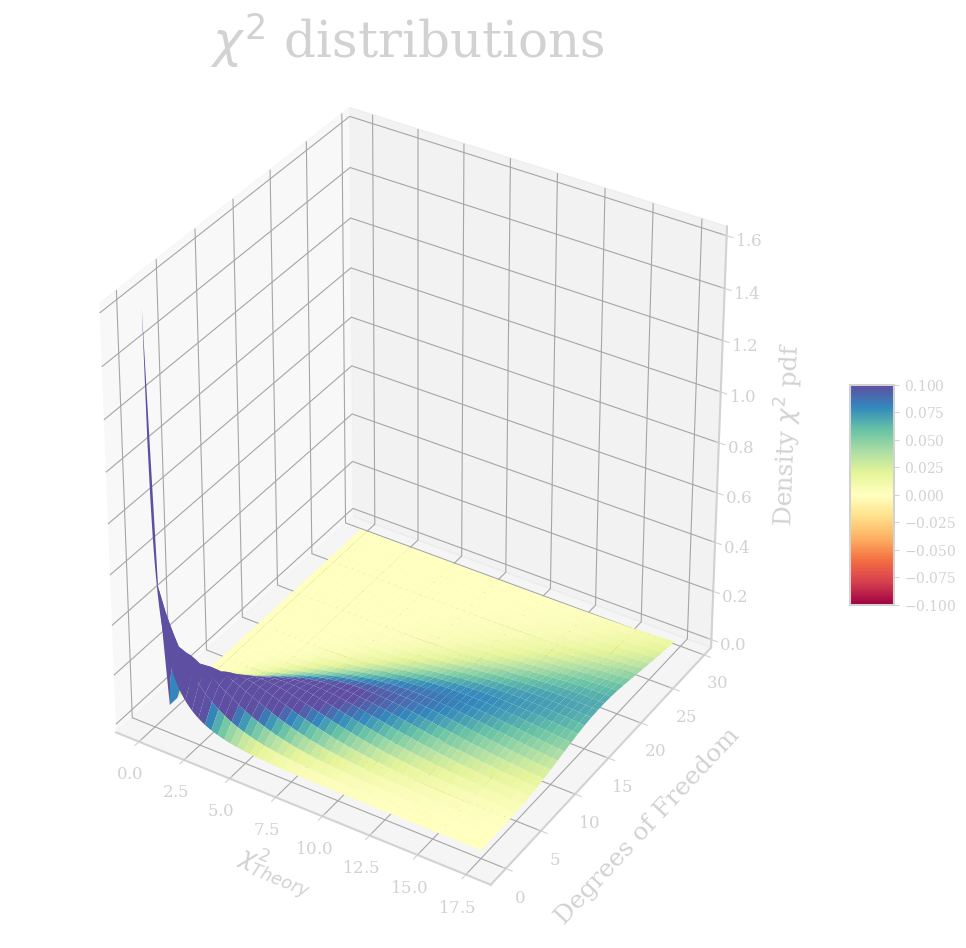

In [36]:
from mpl_toolkits.mplot3d import Axes3D
fig = pyp.figure(figsize=(12,11),dpi=100)
ax1 = fig.add_axes([0.15, 0.15, 0.82, 0.8], projection='3d')

x = np.linspace(0, 17.5, 300);
y = np.linspace(0,29,30);
z = np.zeros((30,300));
for df in range(1,31):
  z[df-1,:] = stats.chi2.pdf(x,df);
  
X,Y = np.meshgrid(x,y);
surf = ax1.plot_surface(X,Y,z,cmap=pyp.cm.Spectral, linewidth=0.5);

cb = fig.colorbar(surf,shrink=0.25,aspect=5, cmap=pyp.cm.Spectral);
ax1.set_zlim(0,1.6);
ax1.patch.set_alpha(0);
ax1.autoscale(enable=True);
ax1.tick_params(axis='both', labelsize=12, direction='out');
ax1.view_init(31,180+90+32);
ax1.set_xlabel(r'$\chi^{2}_{Theory}$', labelpad=10);
ax1.set_ylabel('Degrees of Freedom', labelpad=15);
ax1.set_zlabel('Density $\chi^2$ pdf', labelpad=15);
ax1.set_title('$\chi^2$ distributions\n', size= 36);
fig.tight_layout();


fig.savefig('../img/chi2distroSurf.svg', transparent=True);

# Bendectin Trials

The below table is reproduced from Shapiro et al (1977).

In [37]:
malformations = feather.read_dataframe('data/malformations.feather')

names = ['Uniform', 'Major', 'CentralNervous', 'Cardiovascular', 'Musculoskeletal','Respiratory', 'Gastrointestinal', 'Hypospadias','OtherGenitourinary', 'EyeEar', 'Syndrome', 'Tumors'];
def mapper(xi):
    return(names[xi])
malformations.rename(mapper,axis='index',inplace=True)

malformations


,Bendectin,None,BendectinPercent,ControlPercent
Uniform,55.0,2222.0,0.047049,0.045243
Major,36.0,1357.0,0.030796,0.027630
CentralNervous,7.0,258.0,0.005988,0.005253
Cardiovascular,5.0,399.0,0.004277,0.008124
Musculoskeletal,13.0,382.0,0.011121,0.007778
Respiratory,7.0,211.0,0.005988,0.004296
Gastrointestinal,12.0,289.0,0.010265,0.005884
Hypospadias,5.0,182.0,0.004277,0.003706
OtherGenitourinary,2.0,182.0,0.001711,0.003706
EyeEar,2.0,119.0,0.001711,0.002423


In [38]:
# totals from paper:
nPatients = np.array([1169,49113]);

malTable = pd.DataFrame(
  np.vstack([
    malformations.values.sum(axis=0)[:2],
    nPatients
  ]),
  columns=['Bendectin', 'None'], 
  index=['Malformaed', 'Normal']
)
malTable.applymap(np.int64)

,Bendectin,None
Malformaed,148,5876
Normal,1169,49113


In [39]:
#Cut controls in half
propNorm = malTable['None'][0]/malTable['None'].sum()

cutMal = malTable.copy();
cutMal['None'] = np.array([propNorm*malTable['Bendectin'].sum(),(1-propNorm)*malTable['Bendectin'].sum()]);
cutMal = cutMal.applymap(np.int64);
cutMal = cutMal.applymap(np.float64);


In [40]:
x2Bnd = st.chi2(malTable)
bLong= pd.DataFrame(
  utils.expandGrid(
    malTable.index.tolist(),
    malTable.columns.tolist(),
    doPaste= False,
    expansion= malTable.applymap(np.int64).values.flatten('F')
  ),
  columns = ['Outcome', 'Exposure']
);
bLong.head()

,Outcome,Exposure
0,Malformaed,Bendectin
1,Malformaed,Bendectin
2,Malformaed,Bendectin
3,Malformaed,Bendectin
4,Malformaed,Bendectin


In [41]:
B = 10000
bBoots = np.zeros(B);
bNHST = np.zeros(B);
# make a copy of the data to run the nhst randomization
nhstData = bLong.copy();
cidata = bLong.copy();
nRows = len(bLong.index);

for b in range(B):
  # bootstrap for CI
  cats = malTable.columns.tolist()
  for cat in cats:
    cidata['Outcome'][cidata['Exposure']==cat] = \
        bLong['Outcome'][bLong['Exposure']==cat].sample(
            np.sum(bLong['Exposure']==cat),
            replace=True
        );
  ciTable = pd.crosstab(
      cidata['Exposure'],
      cidata['Outcome']
  );
  #Pandas reorganizes stuff, let's make sure we get it back in order
  #using the original table's ordering
  ciTable = ciTable.loc[malTable.columns.tolist(),malTable.index.tolist()];
  #compute this iteration X2
  bBoots[b] = st.chi2(ciTable)

  # NHST randomization
  nullOutcome = bLong['Outcome'].sample(nRows,replace=True);
  nhstData['Outcome'] = nullOutcome.values;
  NHSTTable = pd.crosstab(
      nhstData['Exposure'],
      nhstData['Outcome']
  );
  #Pandas reorganizes stuff, let's make sure we get it back in order
  NHSTTable = NHSTTable.loc[malTable.columns.tolist(),malTable.index.tolist()];
  bNHST[b] = st.chi2(NHSTTable)

  
bendTable = pd.DataFrame(
   np.vstack([bBoots,bNHST]).T,
   columns=['Bootstraps', 'Null']
 );
bendTable.to_csv('./data/bendectinBootstraps.csv',index=False);

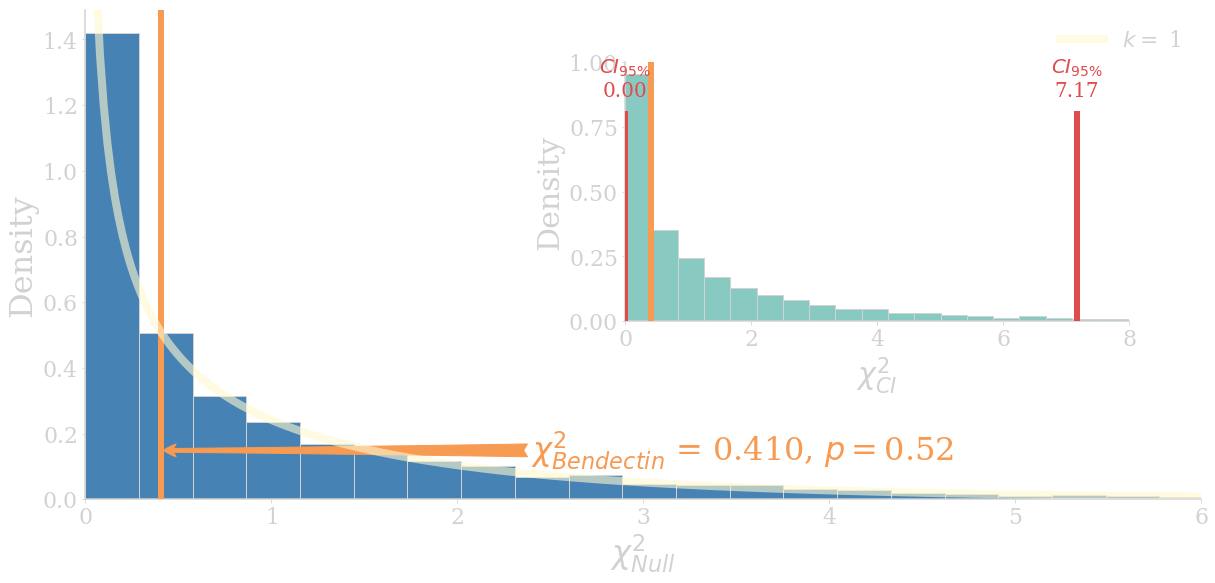

In [42]:
dof = (len(malTable.index)-1)*(len(malTable.columns)-1)
bins = 60
numP = np.sum(bendTable['Null'] >= x2Bnd)
p = np.mean(bendTable['Null'] >= x2Bnd)
if not p:
  p = r'$p<\frac{1}{10000}$'
else:
  p = r'$p=$' + f'{p:.2f}'

fig = pyp.figure(figsize=(20,9))
axs = fig.subplots();
axs = utils.multiX(ax=axs,n=2,concatOriginal=True,concatFirst=True);

'''
0 = base hist and axes lines/labels
1 = annotations (x2 act, etc)
2 = theory overlay
'''

# The histogram
axs[0].hist(
  bendTable['Null'], 
  density= True, 
  bins= bins, 
  color= col['satBlue'],
  edgecolor= col['grey']
);
axs[0].set_xlabel(r'$\chi^{2}_{Null}$', size=32);
axs[0].set_ylabel('Density', size=32);
for ax in axs:
  ax.set_xlim((0,6));
# annotations
axs[1].axvline(x2Bnd, lw=6, color=col['orange']);
axs[1].annotate(
    r'$\chi^{2}_{Bendectin}$' + f' = {x2Bnd:,.3f}'+', '+p,
    xy = (x2Bnd,0.1*axs[1].get_ylim()[1]),
    xytext = (0.4*axs[1].get_xlim()[1],0.1*axs[1].get_ylim()[1]),
    color = col['orange'],
    size=32,
    ha = 'left',
    va = 'center',
    arrowprops= {
        'arrowstyle': 'fancy',
        'edgecolor': col['orange'],
        'facecolor': col['orange']
    },
    zorder=100
);

# Theory
x = np.linspace(*axs[0].get_xlim(),300)
axs[2].plot(
  x, 
  stats.chi2.pdf(x, dof), 
  lw=8, 
  alpha=0.6, 
  label=f"$k=$ {dof}", 
  color=col['offwhite']
);

axs[2].legend(loc='upper right', frameon=False, fontsize=22);
axs[2].patch.set_alpha(0)
axs[2].set_ylim(axs[0].get_ylim());

# Add CI overset
ax2 = fig.add_axes([0.5,0.4,0.35,0.4]);
ax2.hist(
  bendTable['Bootstraps'], 
  density= True, 
  bins= bins, 
  color= col['blue'],
  edgecolor= col['grey']
);
ax2.set_xlabel(r'$\chi^{2}_{CI}$', size=30);
ax2.set_ylabel('Density', size=30);

ax2.patch.set_alpha(0);
ax2.tick_params(axis='both', labelsize=18, direction='out');
ax2.set_xlim((0,8))
#ax2 overlay
ci95 = np.percentile(bendTable['Bootstraps'], q=[2.5, 97.5])
ax3 = ax2.twinx();
ax3.axvline(x2Bnd, lw=6, color=col['orange']);
for ci in ci95:
  ax3.axvline(ci, lw=6, color=col['red'], ymax=0.8);
  ax3.text(
    ci, 
    ax3.get_ylim()[1]*0.85, 
    r'$CI_{95\%}$'+f'\n{ci:.2f}', 
    ha="center",
    color=col['red'], 
    size=20, 
    va="bottom"
  );
ax3.set_xlim(ax2.get_xlim());

for ax in axs+[ax2,ax3]:
    ax.patch.set_alpha(0);
    if ax not in [axs[0],ax2]:
      ax.spines['bottom'].set_visible(False)
      ax.spines['left'].set_visible(False)
      ax.set_yticks([]);
    if ax in [axs[0],ax2]:
        ax.tick_params(axis='both', labelsize = 22, direction= 'out');



fig.savefig('../img/BendectinChi2.svg', transparent=True);

## Bendectin Risk



The biggest problem with the Bendectin trials is they took, literally, every possible congenital malformation and then included those that had 1 or more. This will overweight the control group, because many more cases show up negative, and hide effects of Bendectin on congenital malformations.

But how do we calculate risk?

Consider the following subset of our Bendectin Data:

<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Bendectin</th>
      <th>None</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Malformaed</th>
      <td>12</td>
      <td>289</td>
    </tr>
    <tr>
      <th>Normal</th>
      <td>1169</td>
      <td>49113</td>
    </tr>
  </tbody>
</table>
</div>

For reference, the table is shaped like:
$${\displaystyle {\begin{pmatrix}a_1&a_2\\b_1&b_2\end{pmatrix}}}$$

<ul>
  <li class="fragment">Risk of GI malformation on Bendectin: $\frac{a_1}{a_1+b_1}$</li>
  <li class="fragment">Risk of GI malformation <span class="red">not</span> on Bendectin: $\frac{a_2}{a_2+b_2}$</li>
  <li class="fragment">Define Relative Risk: $Risk_{Bendectin} / Risk_{None}$</li>
</ul>

$$RR = \frac{ \frac{a_1}{a_1+b_1} }{ \frac{a_2}{a_2+b_2} }$$

Thus,

$$RR = \frac{ \frac{12}{12+1,169} }{ \frac{289}{289+49,113} } = 1.744$$

How do we bootstrap this?




In [44]:
riskMal = pd.DataFrame(malformations.loc['Gastrointestinal']).T;
riskMal

,Bendectin,None,BendectinPercent,ControlPercent
Gastrointestinal,12.0,289.0,0.010265,0.005884


In [45]:
riskMal.values[0][:2]

array([ 12., 289.])

In [46]:
nPatients = np.array([1169,49113]);

riskTable = pd.DataFrame(
  np.vstack([
    riskMal.values[0][:2],
    nPatients
  ]),
  columns=['Bendectin', 'None'], 
  index=['Malformaed', 'Normal']
)
riskTable.applymap(np.int64)

,Bendectin,None
Malformaed,12,289
Normal,1169,49113


<table>
<thead>
<tr>
<th style="text-align:left;">
</th>
<th style="text-align:right;">
Malformed
</th>
<th style="text-align:right;">
CI2.5
</th>
<th style="text-align:right;">
CI97.5
</th>
<th style="text-align:right;">
pValue
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;">
Uniform
</td>
<td style="text-align:right;">
1.0399216
</td>
<td style="text-align:right;">
0.7753295
</td>
<td style="text-align:right;">
1.3239468
</td>
<td style="text-align:right;">
0.7174
</td>
</tr>
<tr>
<td style="text-align:left;">
Major
</td>
<td style="text-align:right;">
1.1145630
</td>
<td style="text-align:right;">
0.7641910
</td>
<td style="text-align:right;">
1.4983742
</td>
<td style="text-align:right;">
0.5388
</td>
</tr>
<tr>
<td style="text-align:left;">
CentralNervous
</td>
<td style="text-align:right;">
1.1398830
</td>
<td style="text-align:right;">
0.3410144
</td>
<td style="text-align:right;">
2.0728015
</td>
<td style="text-align:right;">
0.6993
</td>
</tr>
<tr>
<td style="text-align:left;">
Cardiovascular
</td>
<td style="text-align:right;">
0.5264766
</td>
<td style="text-align:right;">
0.1055083
</td>
<td style="text-align:right;">
1.0470719
</td>
<td style="text-align:right;">
0.0484
</td>
</tr>
<tr>
<td style="text-align:left;">
Musculoskeletal
</td>
<td style="text-align:right;">
1.4297560
</td>
<td style="text-align:right;">
0.7118827
</td>
<td style="text-align:right;">
2.2793782
</td>
<td style="text-align:right;">
0.2692
</td>
</tr>
<tr>
<td style="text-align:left;">
Respiratory
</td>
<td style="text-align:right;">
1.3937906
</td>
<td style="text-align:right;">
0.4210477
</td>
<td style="text-align:right;">
2.5663569
</td>
<td style="text-align:right;">
0.3900
</td>
</tr>
<tr>
<td style="text-align:left;">
Gastrointestinal
</td>
<td style="text-align:right;">
1.7444774
</td>
<td style="text-align:right;">
0.8079031
</td>
<td style="text-align:right;">
2.8700643
</td>
<td style="text-align:right;">
0.2030
</td>
</tr>
<tr>
<td style="text-align:left;">
Hypospadias
</td>
<td style="text-align:right;">
1.1541987
</td>
<td style="text-align:right;">
0.2347444
</td>
<td style="text-align:right;">
2.3198622
</td>
<td style="text-align:right;">
0.6462
</td>
</tr>
<tr>
<td style="text-align:left;">
OtherGenitourinary
</td>
<td style="text-align:right;">
0.4616795
</td>
<td style="text-align:right;">
0.0000000
</td>
<td style="text-align:right;">
1.2222851
</td>
<td style="text-align:right;">
0.0820
</td>
</tr>
<tr>
<td style="text-align:left;">
EyeEar
</td>
<td style="text-align:right;">
0.7060980
</td>
<td style="text-align:right;">
0.0000000
</td>
<td style="text-align:right;">
1.8793885
</td>
<td style="text-align:right;">
0.5318
</td>
</tr>
<tr>
<td style="text-align:left;">
Syndrome
</td>
<td style="text-align:right;">
1.1253437
</td>
<td style="text-align:right;">
0.0000000
</td>
<td style="text-align:right;">
2.5942169
</td>
<td style="text-align:right;">
0.7706
</td>
</tr>
<tr>
<td style="text-align:left;">
Tumors
</td>
<td style="text-align:right;">
0.2577474
</td>
<td style="text-align:right;">
0.0000000
</td>
<td style="text-align:right;">
0.8585105
</td>
<td style="text-align:right;">
0.0223
</td>
</tr>
</tbody>
</table>


In [47]:
### RUN THIS

bootTable = pd.read_csv('./data/giboots.csv');
bootTable.head(10)

,Boostrap,Null
0,1.256487,1.294916
1,1.790243,1.443740
2,1.505610,0.854498
3,1.942052,1.896413
4,1.700538,1.000306
5,1.731525,0.565829
6,2.556773,1.294916
7,0.972632,0.709676
8,1.409065,1.593590
9,1.972093,1.443740


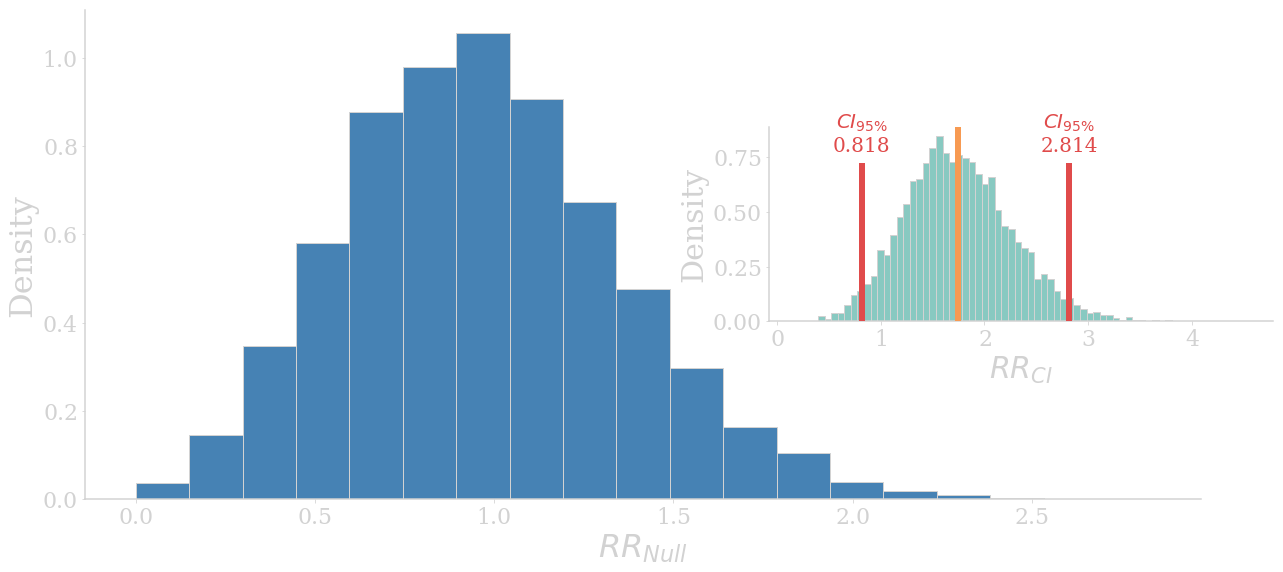

In [56]:

p = 0.2030
if not p:
  p = r'$p<\frac{1}{10000}$'
else:
  p = r'$p=$' + f'${p:.4f}'
bins = 'auto'

fig = pyp.figure(figsize=(20,9))
axs = fig.subplots();
axs = utils.multiX(ax=axs,n=2,concatOriginal=True,concatFirst=True);

'''
0 = base hist and axes lines/labels
1 = annotations (x2 act, etc)
2 = theory overlay
'''

# The histogram
axs[0].hist(
  bootTable['Null'], 
  density= True,
  bins=19,
  color= col['satBlue'],
  edgecolor= col['grey']
);
axs[0].set_xlabel(r'$RR_{Null}$', size=32);
axs[0].set_ylabel('Density', size=32);

# annotations
# axs[1].annotate(
#     r'$\chi^{2}_{Hospitals}$' + f' = {x2Hosp:,.0f}',
#     xy = (axs[1].get_xlim()[1],0.1*axs[1].get_ylim()[1]),
#     xytext = (0.8*axs[1].get_xlim()[1],0.1*axs[1].get_ylim()[1]),
#     color = col['orange'],
#     size=32,
#     ha = 'right',
#     va = 'center',
#     arrowprops= {
#         'arrowstyle': 'fancy',
#         'edgecolor': col['orange'],
#         'facecolor': col['orange']
#     },
#     zorder=100
# );

# Theory
# x = np.linspace(*axs[0].get_xlim(),300)
# axs[2].plot(
#   x, 
#   stats.chi2.pdf(x, dof), 
#   lw=8, 
#   alpha=0.6, 
#   label=f"$k=$ {dof}", 
#   color=col['offwhite']
# );
# axs[2].legend(loc='upper right', frameon=False, fontsize=22);
# axs[2].patch.set_alpha(0)
# axs[2].set_ylim(axs[0].get_ylim());

# Add CI overset
ax2 = fig.add_axes([0.6,0.4,0.35,0.3]);
ax2.hist(
  bootTable['Boostrap'], 
  density= True, 
  bins= bins, 
  color= col['blue'],
  edgecolor= col['grey']
);
ax2.set_xlabel(r'$RR_{CI}$', size=30);
ax2.set_ylabel('Density', size=30);

ax2.patch.set_alpha(0);
ax2.tick_params(axis='both', labelsize=18, direction='out');

#ax2 overlay
ci95 = np.percentile(bootTable['Boostrap'], q=[2.5, 97.5])
ax3 = ax2.twinx();
ax3.axvline(1.744, lw=6, color=col['orange']);
for ci in ci95:
  ax3.axvline(ci, lw=6, color=col['red'], ymax=0.8);
  ax3.text(
    ci, 
    ax3.get_ylim()[1]*0.85, 
    r'$CI_{95\%}$'+f'\n{ci:.3f}', 
    ha="center",
    color=col['red'], 
    size=20, 
    va="bottom"
  );
ax3.set_xlim(ax2.get_xlim());

for ax in axs+[ax2,ax3]:
    ax.patch.set_alpha(0);
    if ax not in [axs[0],ax2]:
      ax.spines['bottom'].set_visible(False)
      ax.spines['left'].set_visible(False)
      ax.set_yticks([]);
    if ax in [axs[0],ax2]:
      ax.tick_params(axis='both', labelsize = 22, direction= 'out');
# for ax in axs:
#   ax.set_xlim((0,26));


fig.savefig('../img/GIRisk.svg', transparent=True);